In [4]:
import numpy as np
import matplotlib.pyplot as plt 
from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS
from qiskit import QuantumCircuit 
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

algorithm_globals.random_seed = 42

## Simple Classification 

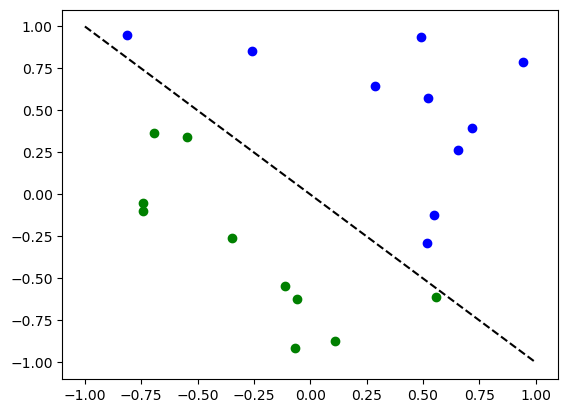

In [5]:
# Dataset dimension and size selection
num_inputs = 2
num_samples = 20

# Generating random input coordinates and binary labels
X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1
y01 = 1 * (np.sum(X, axis=1) >= 0) # binary labels {0,1} used in Sampler case
y = 2 * y01 - 1 # binary labels {+\- 1} used in Estimator case

X_ = Tensor(X)
y01_ = Tensor(y01).reshape(len(y)).long()
y_ = Tensor(y).reshape(len(y), 1)

# Plotting 
for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else: 
        plt.plot(x[0], x[1], "go")
plt.plot([-1,1],[1,-1], "--", color="black")
plt.show()

### `EstimatorQNN` classification case

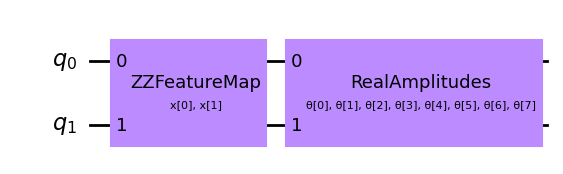

In [6]:
# Circuit instantiation
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs)
qc = QuantumCircuit(num_inputs)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)
qc.draw(output='mpl', style='clifford')

In [9]:
from qiskit.primitives import StatevectorEstimator as Estimator

estimator = Estimator()
qnn1 = EstimatorQNN(circuit=qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, estimator=estimator,)

initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn1.num_weights) - 1)
model1 = TorchConnector(qnn1, initial_weights=initial_weights)
print("Initial weights: ", initial_weights)

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


Initial weights:  [ 0.0364991  -0.0720495  -0.06001836 -0.09852755  0.05738488  0.03297017
  0.04103308  0.05614581]


In [10]:
# Single-input test 
model1(X_[0, :])

tensor([-0.3404], grad_fn=<_TorchNNFunctionBackward>)

In [11]:
# Optimization and loss function
optimizer = LBFGS(model1.parameters())
f_loss = MSELoss(reduction="sum")

model1.train()

def closure():
    optimizer.zero_grad()
    loss = f_loss(model1(X_), y_)
    loss.backward()
    print(loss.item())
    return loss

optimizer.step(closure)

25.1903076171875
22.72208595275879
20.487462997436523
26.334531784057617
23.88776969909668
21.029518127441406
26.44255828857422
18.44052505493164
20.83500099182129
17.748132705688477
17.95907211303711
17.574798583984375
16.897579193115234
16.253719329833984
15.189994812011719
15.612309455871582
14.848206520080566
15.023629188537598
14.829553604125977
15.400739669799805


tensor(25.1903, grad_fn=<MseLossBackward0>)

Accuracy:  0.8


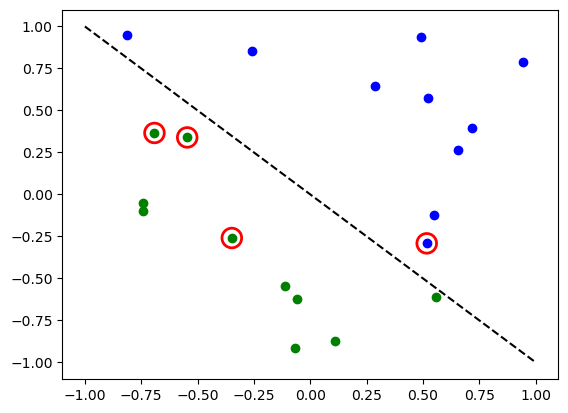

In [12]:
# Evaluation 
model1.eval()
y_predict = []

for x, y_target in zip(X, y):
    output = model1(Tensor(x))
    y_predict += [np.sign(output.detach().numpy())[0]]
    
print("Accuracy: ", sum(y_predict == y) / len(y))

# Plotting -- red == wrongly classified 
for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else: 
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidth=2)

plt.plot([-1,1], [1,-1], "--", color="black")
plt.show()

### `SamplerQNN` classification case

In [14]:
from qiskit.primitives import StatevectorSampler as Sampler

# Circuit instantiation
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs, entanglement="linear", reps=1)
qc = QuantumCircuit(num_inputs)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

sampler = Sampler()

parity = lambda x: "{:b}".format(x).count("1") % 2 # interpret function
output_shape = 2 # parity = 0, 1
qnn2 = SamplerQNN(circuit=qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, interpret=parity, output_shape=output_shape, sampler=sampler,)

initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn2.num_weights) - 1)
print("Initial weights:", initial_weights)
model2 = TorchConnector(qnn2, initial_weights)

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


Initial weights: [-0.00821684  0.01374824 -0.0720406  -0.07709399]


In [16]:
# Optimization and loss function 
optimizer = LBFGS(model2.parameters())
f_loss = CrossEntropyLoss() # Since output in [0,1] range

model2.train()

def closure():
    optimizer.zero_grad(set_to_none=True)
    loss = f_loss(model2(X_), y01_)
    loss.backward()
    print(loss.item())
    return loss

optimizer.step(closure)

0.6884295344352722
0.6814602613449097
0.6723071932792664
0.6713187098503113
0.6496763825416565
0.6537489891052246
0.6661040782928467
0.6813574433326721
0.7112417817115784
0.7351897954940796
0.741625964641571
0.7438763380050659
0.6555472612380981
0.7153696417808533
0.7863335609436035
0.7825598120689392
0.750907301902771
0.6322504281997681
0.7804462909698486
0.7279905080795288


tensor(0.6884, grad_fn=<NllLossBackward0>)

Accuracy:  0.55


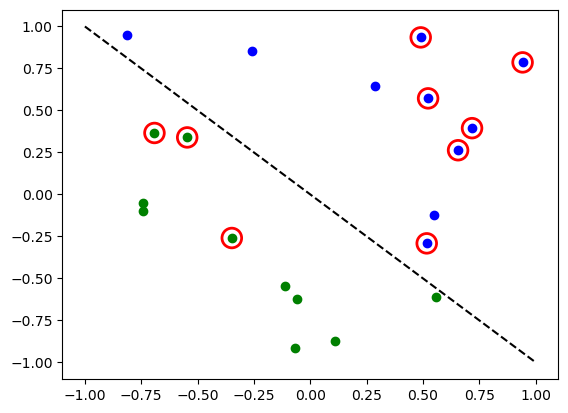

In [17]:
# Evaluation 
model2.eval()
y_predict = []

for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]
    
print("Accuracy: ", sum(y_predict == y01) / len(y01))

# Plotting -- red == wrongly classified 
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else: 
        plt.plot(x[0], x[1], "go")
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidth=2)

plt.plot([-1,1], [1,-1], "--", color="black")
plt.show()

## Simple Regression

### `EstimatorQNN` regression case

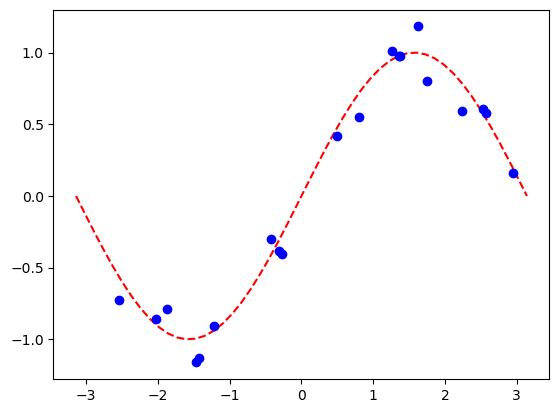

In [19]:
# Random dataset
num_samples = 20
eps = 0.2
lb, ub = -np.pi, np.pi
f = lambda x: np.sin(x)

X = (ub - lb) * algorithm_globals.random.random([num_samples, 1]) + lb
y = f(X) + eps * (2 * algorithm_globals.random.random([num_samples, 1]) - 1)
plt.plot(np.linspace(lb, ub), f(np.linspace(lb, ub)), "r--")
plt.plot(X, y, "bo")
plt.show()

In [20]:
# Circuit instantiation 
param_x = Parameter("x")
feature_map = QuantumCircuit(1, name="fm")
feature_map.ry(param_x, 0)

param_y = Parameter("y")
ansatz = QuantumCircuit(1, name="vf")
ansatz.ry(param_y, 0)

qc = QuantumCircuit(1)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

qnn3 = EstimatorQNN(circuit=qc, input_params=[param_x], weight_params=[param_y], estimator=estimator,)

initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn3.num_weights) - 1)
model3 = TorchConnector(qnn3, initial_weights)

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


In [21]:
# Optimization and loss function 
optimizer = LBFGS(model3.parameters())
f_loss = MSELoss(reduction="sum")

model3.train()

def closure():
    optimizer.zero_grad(set_to_none=True)
    loss = f_loss(model3(Tensor(X)), Tensor(y))
    loss.backward()
    print(loss.item())
    return loss

optimizer.step(closure)

21.341815948486328
3.070826768875122
0.3025919198989868
0.30312371253967285
0.27484917640686035
0.2600521445274353
0.287878155708313
0.2593724727630615
0.30079132318496704
0.3138892948627472
0.2596004605293274
0.28739047050476074
0.2611989676952362
0.3029548227787018
0.2829611599445343
0.3037792444229126
0.2827876806259155
0.3088214099407196
0.2630828619003296
0.2718818187713623


tensor(21.3418, grad_fn=<MseLossBackward0>)

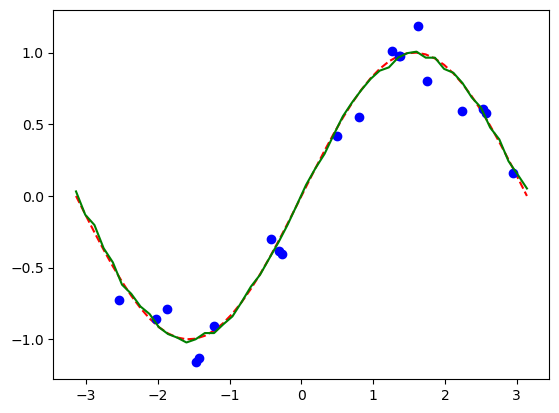

In [22]:
# Plotting 
plt.plot(np.linspace(lb, ub), f(np.linspace(lb, ub)), "r--")

plt.plot(X, y, "bo")

model3.eval()
y_ = []
for x in np.linspace(lb, ub):
    output = model3(Tensor([x]))
    y_ += [output.detach().numpy()[0]]
plt.plot(np.linspace(lb, ub), y_, "g-")
plt.show()